In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.stats import boxcox

In [27]:
airlines_passengers = pd.read_csv("international-airline-passengers.csv") #series1
female_births = pd.read_csv("daily-total-female-births-in-cal.csv") #series2
sales_of_company = pd.read_csv('monthly-sales-of-company-x-jan-6.csv') #series3

# Отображение графика

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
all_series = {
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Daily total female births in California": female_births["Count"],
    "Monthly sales of company" : sales_of_company["Count"]
}

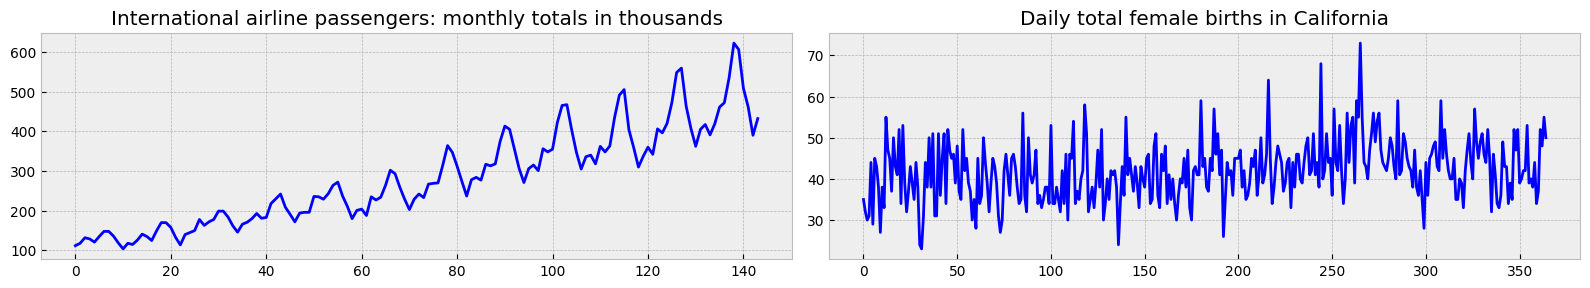

In [5]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)

        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)

    plt.tight_layout()

In [29]:
series1 = all_series['International airline passengers: monthly totals in thousands']
series2 = all_series['Daily total female births in California']
series3 = all_series['Monthly sales of company']

Для временного ряда series2 можно использовать метод скольщяего среднего т.к. временной ряд представляет собой шум и среднение методом скользящего среднего позволит увидеть тренды

In [7]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

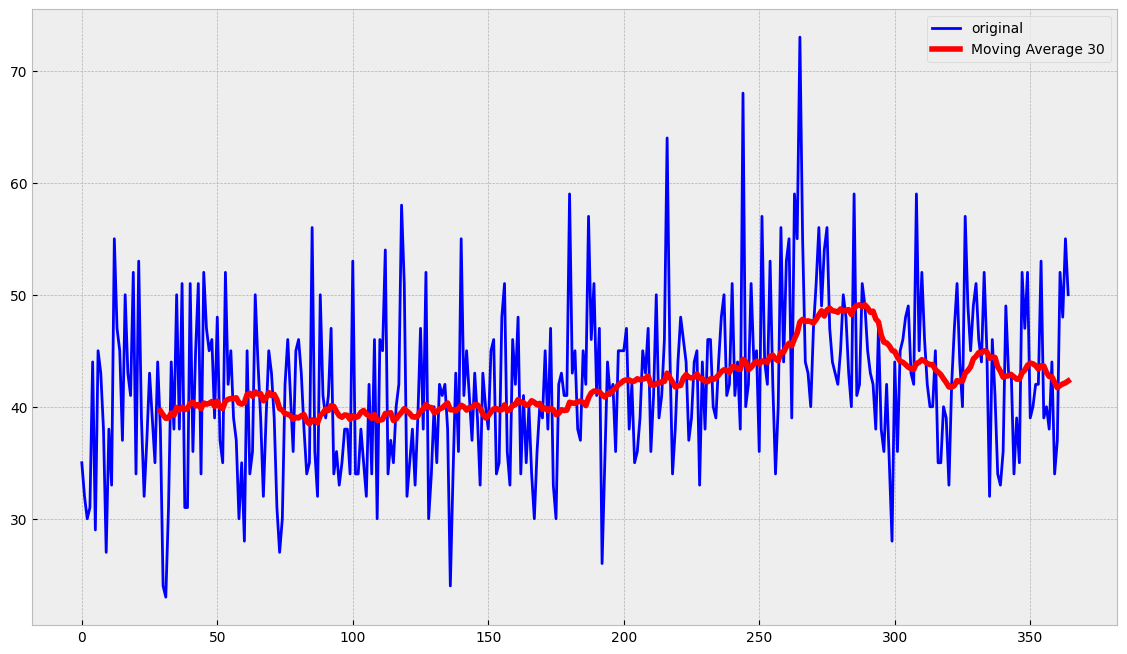

In [8]:
ser = moving_average(series2, 30)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series2, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label=f'Moving Average {30}')
    plt.legend()

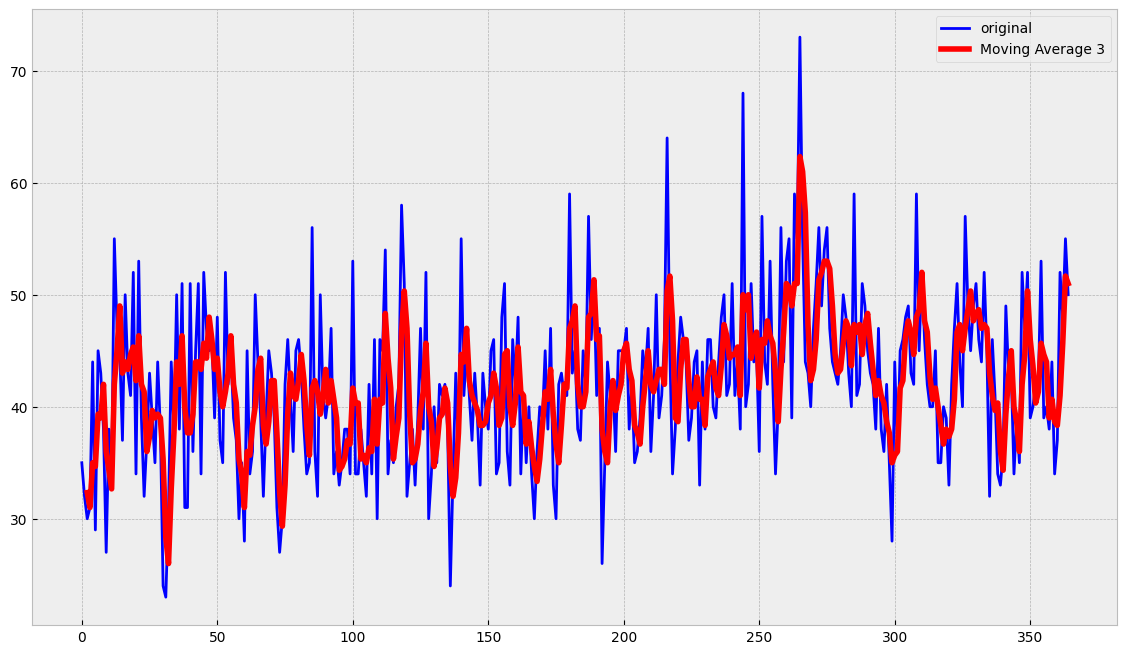

In [9]:
ser = moving_average(series2, 3)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series2, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label=f'Moving Average {3}')
    plt.legend()

В series1 присутствует и тренд и сезонность. Для таких данных лучше всего использовать модель тройного экспоненциального сглаживания

In [10]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [11]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [12]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [13]:
def plot_tema(alpha, beta, gamma, ser=series1, ser_to_plot=series1, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

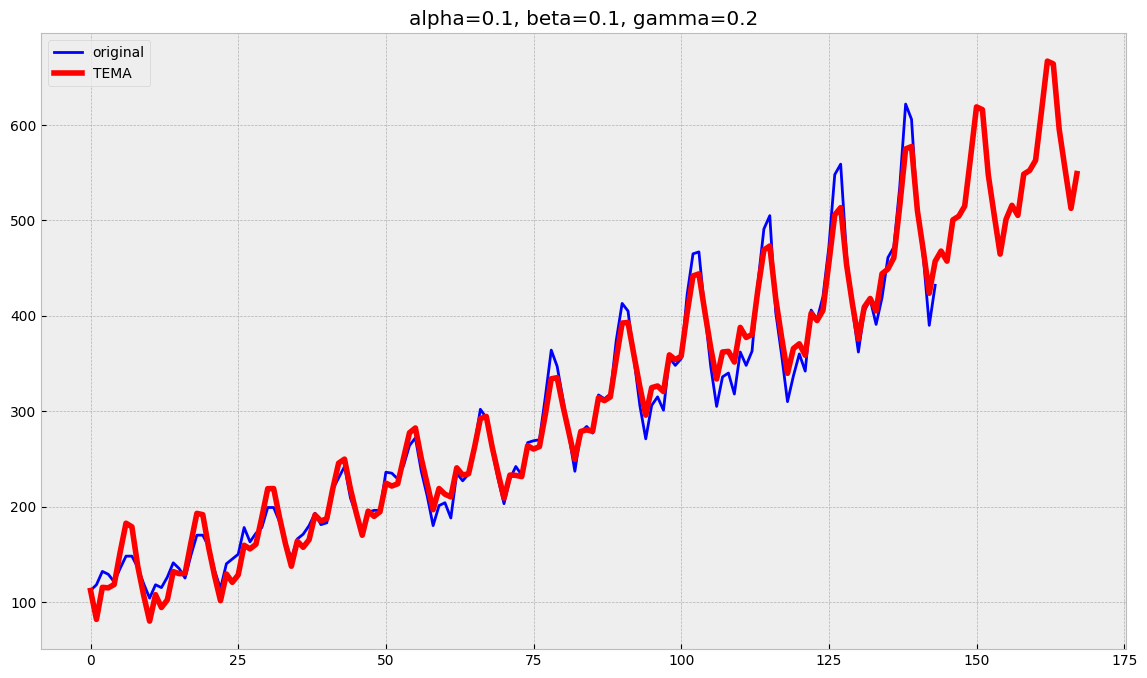

In [14]:
plot_tema(0.1, 0.1, 0.2)

In [15]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [16]:
len(series1)

144

In [17]:
train, test, val = series1[:60], series1[60:70], series1[70:]

In [18]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [19]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [30]:
alpha_opt, beta_opt, gamma_opt = opt.x

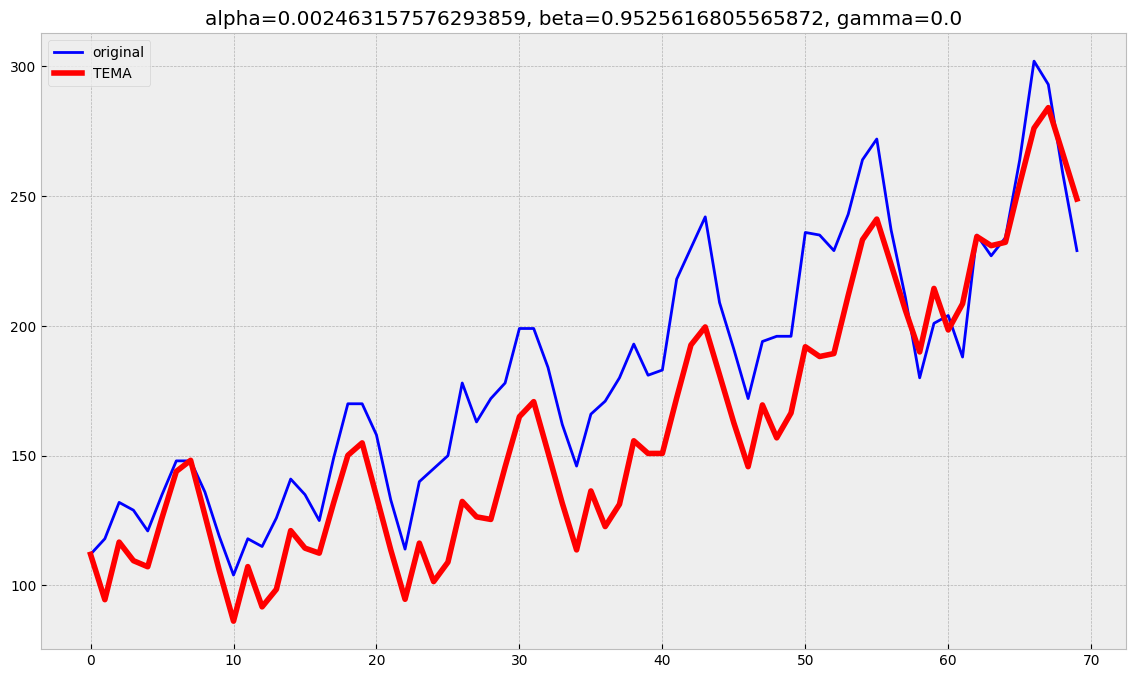

In [21]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series1[:70], n_preds=len(test))

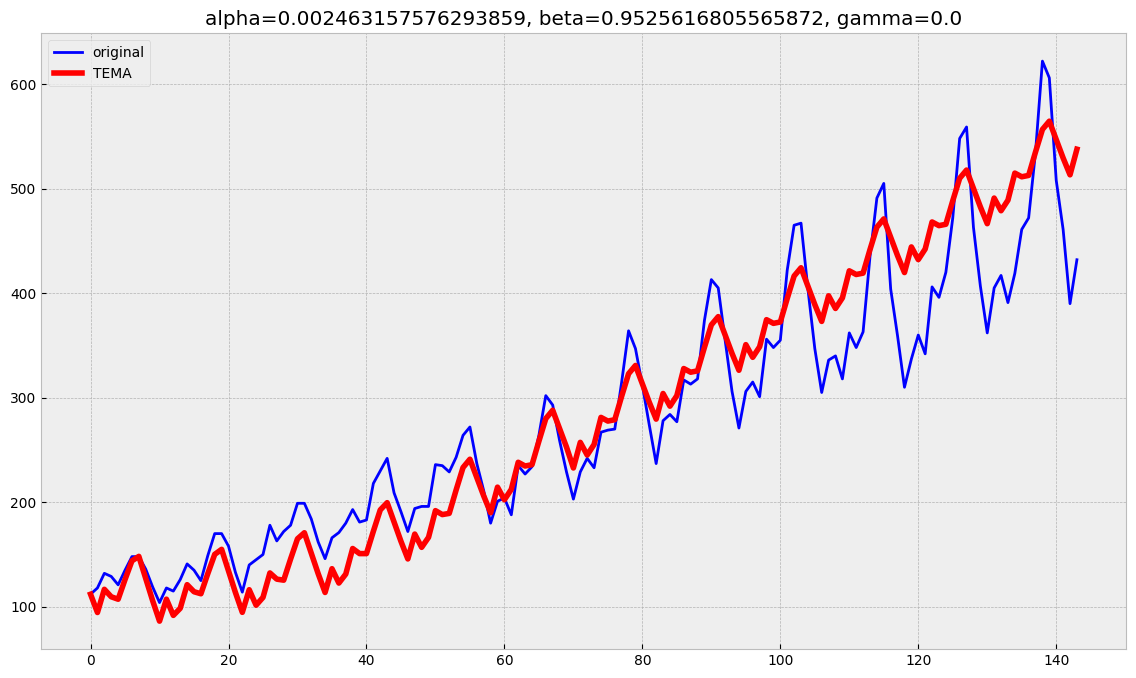

In [22]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series1[:70], ser_to_plot=series1, n_preds=len(val))

------------------------------------------------------

Не очень понравился график и было решено выровнять дисперсию и попытаться снова

In [37]:
from scipy.stats import boxcox

In [38]:
series1 = boxcox(series1, 0)

In [39]:
train, test, val = series1[:60], series1[60:70], series1[70:]

In [40]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [41]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [42]:
alpha_opt, beta_opt, gamma_opt = opt.x

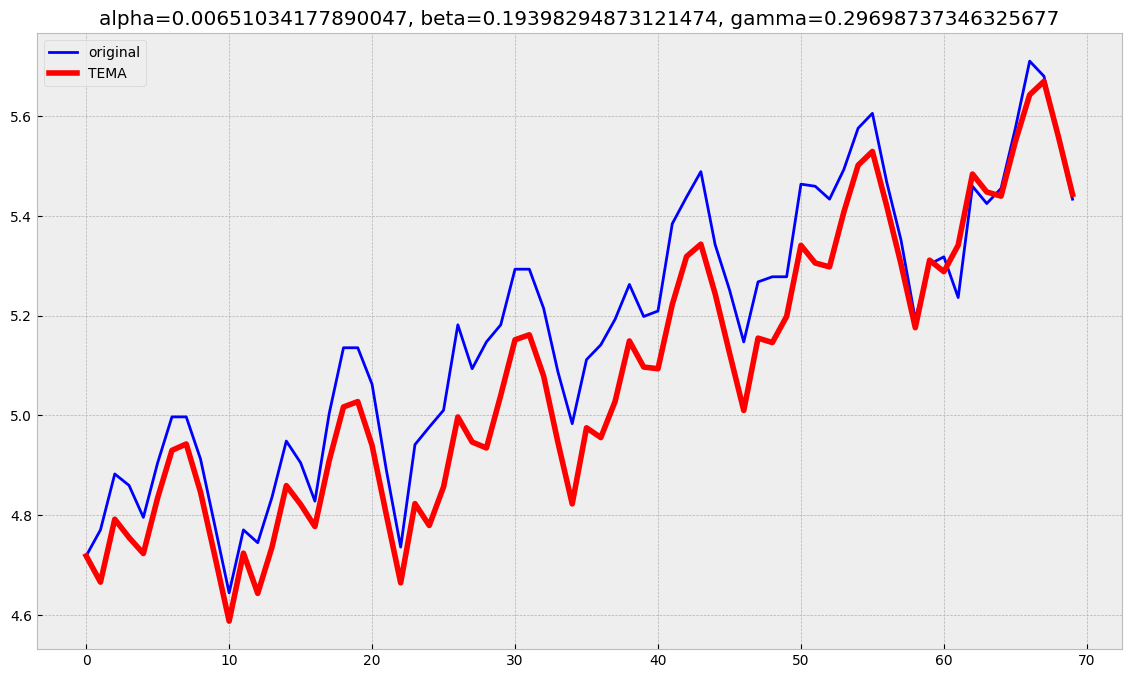

In [43]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series1[:70], n_preds=len(test))

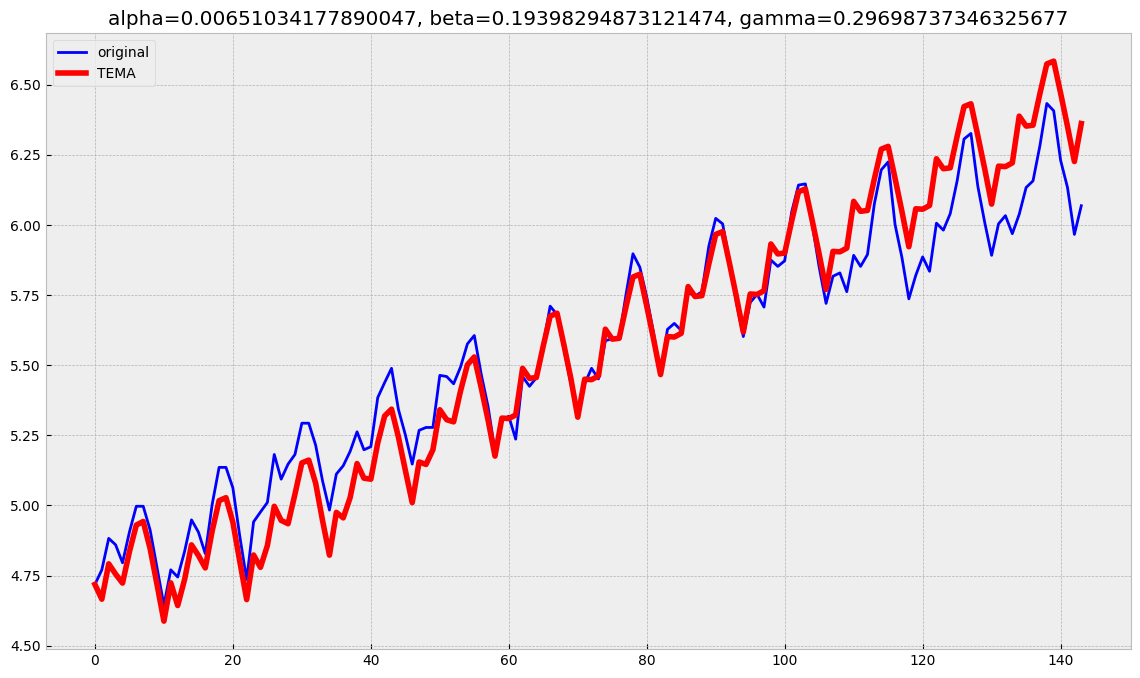

In [44]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series1[:70], ser_to_plot=series1, n_preds=len(val))

Стало немного лучше, но все равно не идеально